In [1]:
import matplotlib
import numpy
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from classes import *
from utils import *

g = torch.Generator().manual_seed(42)


# Andrej Karpathy Lecture Notes

Modularize and explained in a concise manner the first five lectures "Zero to Hero" Lectures

### Download Data

In [2]:
words = open("names.txt","r").read().splitlines() # Download Dataset

b = {} # bigram counts statistics

for w in words:          
    chs = ["<S>"] + list(w) + ["<S>"]

    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0) + 1

In [3]:
chars = sorted(list(set("".join(words))))             # Unique, sorted list of characters
stoi  = {ch: 1 + idx for idx, ch in enumerate(chars)} # Dictionary: character to index (starting from 1)
stoi["."] = 0                                         # Assign 0 to special token '.'
itos  = {i: ch for ch, i in stoi.items()}             # Inverse dictionary: index to character


### Exact Method character generation

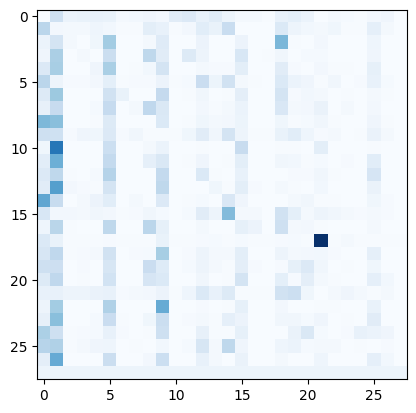

In [4]:
N = torch.zeros((28,28), dtype = torch.int32) # 28x28 matrix for bigram counts

for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

# Probability matrix P
P = (N+1).float()
P /=  P.sum(1, keepdims = True)

plt.imshow(P, cmap = 'Blues')


In [5]:
# Generate 10 words
for i in range(5): 
    ix = 0   # index current character
    out = [] # word vector

    while True:
        p = P[ix]                                                                            # probability vector for the next character
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item() # index generated for next character 
        out.append(itos[ix])                                                                 # append next character to the word vector
        if ix == 0:
            break
    print("".join(out))

ya.
syahavilin.
dleekahmangonya.
tryahe.
chen.


In [6]:
# Calculate the negative log likelihood (NLL) of the dataset: llhood = 1/N * sum(log(P(w_i|w_{i-1})))
log_likelihood = 0
n = 0
for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        N[ix1,ix2] += 1
        logprob = torch.log(prob)
        log_likelihood += logprob
        n +=1 

nll = -log_likelihood
print(f"Loss is {nll/n}")

Loss is 2.4544754028320312


### Training Method

In [7]:
# Create training set bigrams (x,y)
xs, ys = [], []

for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)        
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Randomly initialize the 27 neuron's weight
W = torch.randn((27,27), requires_grad= True)

# training loop
for i in range(100):

    # forward pass
    xenc = F.one_hot(xs, num_classes = 27).float()
    logits = xenc @ W # log-counts
    counts = logits.exp() # equivalent N
    probs = counts / counts.sum(1, keepdims = True)
    loss = - probs[torch.arange(logits.shape[0]),ys].log().mean() + 0.01 * (W**2).mean()

    # backward pass
    W.grad = None
    loss.backward()
    W.data += -3 * W.grad

In [8]:
for i in range(5): # Generate 5 words
    ix = 0
    out = []

    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        logits = xenc @ W # log-counts
        counts = logits.exp() # equivalent N
        probs = counts / counts.sum(1, keepdims = True)
        ix = torch.multinomial(probs, num_samples = 1 , replacement = True, generator = g).item()

        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))

ena.
dlyamjiae.
y.
keles.
ld.


## Makemore: Part 2 MLP

In [ ]:
block_size = 3 # context length

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

In [11]:
# MLP revisted
n_embd = 10
n_hidden = 100 
vocab_size = len(itos)

C = torch.randn((vocab_size,n_embd), generator = g)
layers = [
    Linear(n_embd * block_size,n_hidden),BatchNorm1D(n_hidden),Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden),Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    # Last layer: make less confident
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 1.0 # 5.3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"There is a total of {sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True # Allow gradients to be calculated

There is a total of 47551 parameters


In [12]:
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # mini batch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]                     # embed the characters into vectors
    x = emb.view(emb.shape[0] ,-1)  # concatenate the vectors
    for layer in layers:            # apply the layers
        x = layer(x)
    loss = F.cross_entropy(x,Yb)    # cross entropy loss

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # track stats
    if i %  10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  10000: 3.3014


layer 2 (      Tanh): mean +0.55, std 0.50, saturated: 14.66%
layer 5 (      Tanh): mean +0.55, std 0.51, saturated: 14.41%
layer 8 (      Tanh): mean +0.55, std 0.52, saturated: 15.22%
layer 11 (      Tanh): mean +0.56, std 0.52, saturated: 13.50%
layer 14 (      Tanh): mean +0.56, std 0.53, saturated: 12.78%


Text(0.5, 1.0, 'activation distribution')

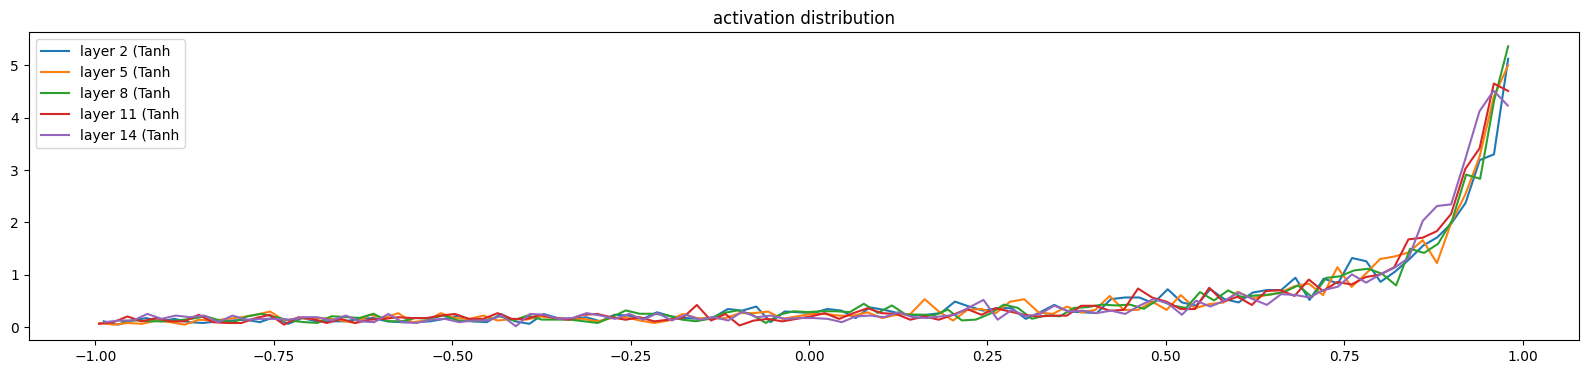

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.847078e-03
layer 5 (      Tanh): mean +0.000000, std 3.446849e-03
layer 8 (      Tanh): mean -0.000000, std 3.208269e-03
layer 11 (      Tanh): mean +0.000000, std 3.147452e-03
layer 14 (      Tanh): mean +0.000000, std 3.197322e-03


Text(0.5, 1.0, 'gradient distribution')

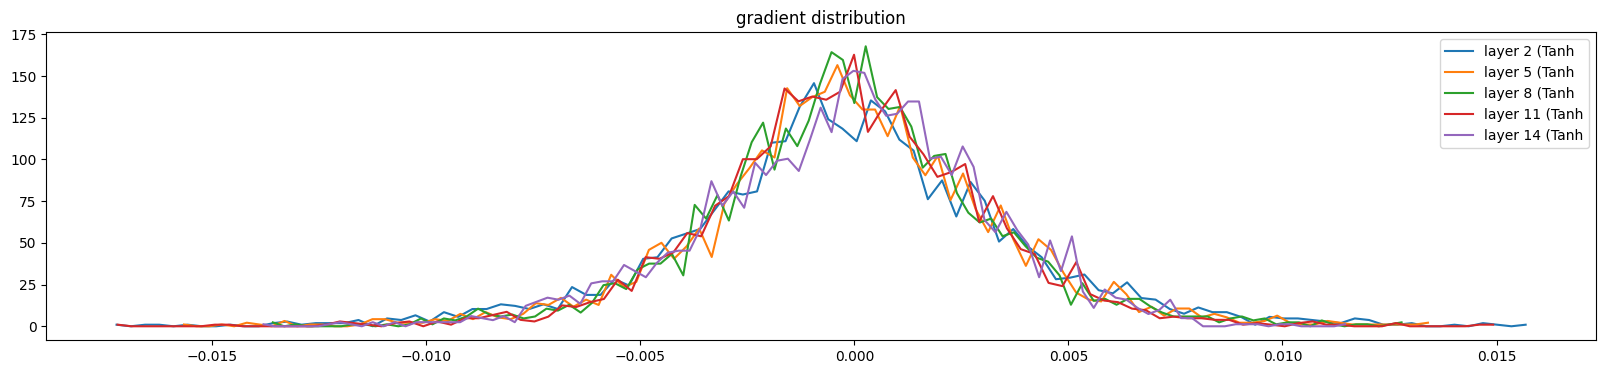

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

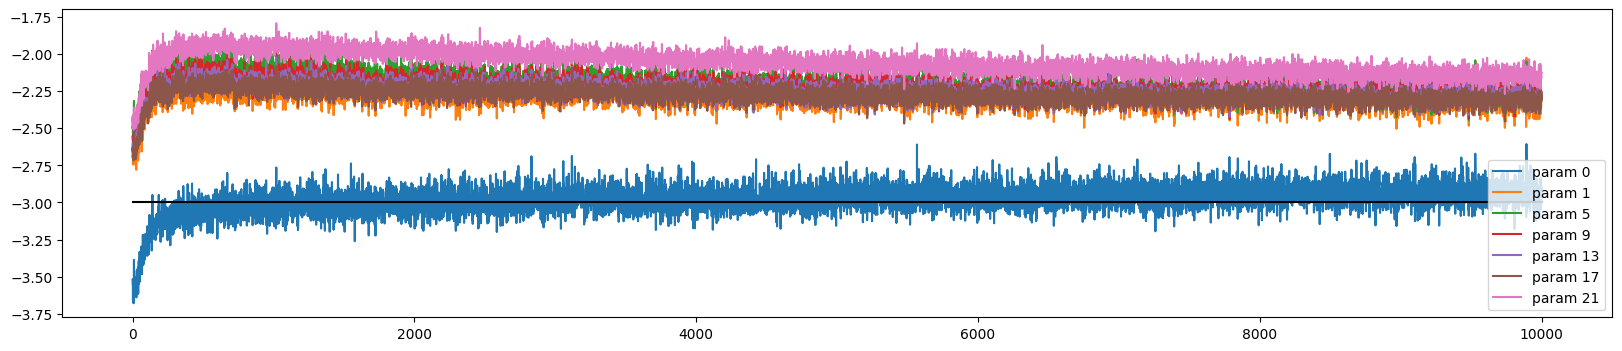

In [15]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

weight   (27, 10) | mean -0.000000 | std 1.149311e-02 | grad:data ratio 1.255786e-02
weight  (30, 100) | mean +0.000025 | std 1.082357e-02 | grad:data ratio 5.127060e-02
weight (100, 100) | mean -0.000007 | std 6.619476e-03 | grad:data ratio 5.405879e-02
weight (100, 100) | mean -0.000001 | std 6.614523e-03 | grad:data ratio 5.535636e-02
weight (100, 100) | mean -0.000088 | std 6.231313e-03 | grad:data ratio 5.309416e-02
weight (100, 100) | mean -0.000043 | std 5.753460e-03 | grad:data ratio 4.963109e-02
weight  (100, 27) | mean -0.000049 | std 1.035137e-02 | grad:data ratio 6.920957e-02


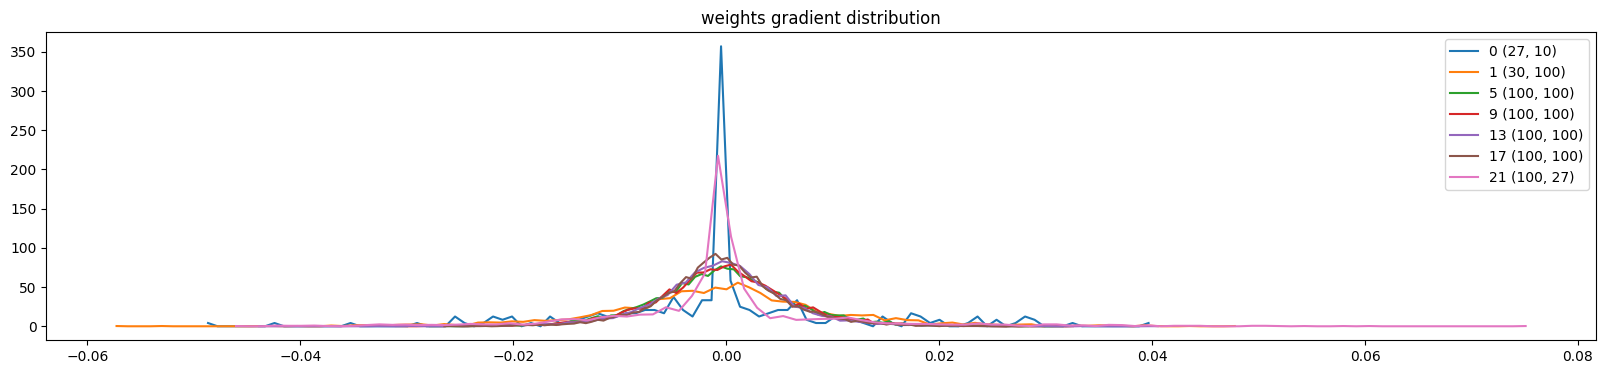

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

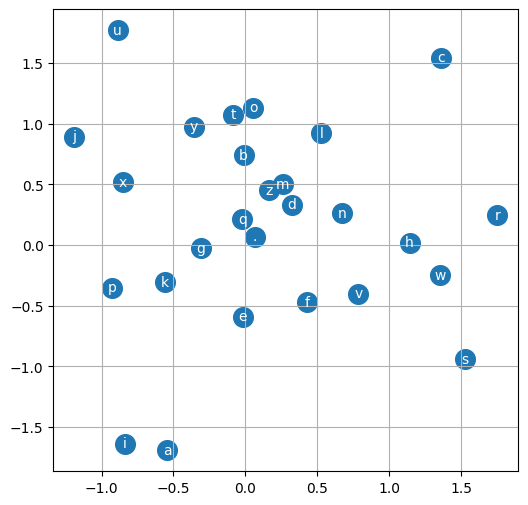

In [17]:
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")

plt.grid("minor")

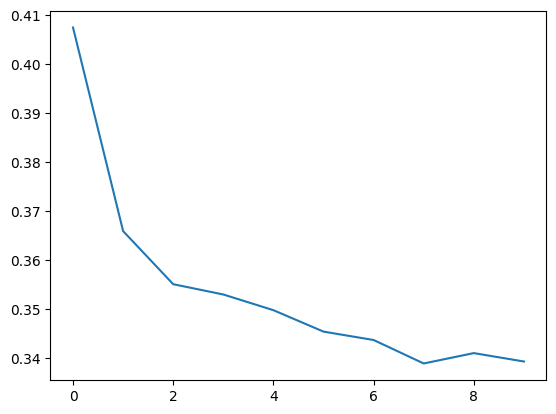

In [18]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

# Makemore Part 5: Building a WaveNet

In [ ]:
block_size = 8 # context length

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

In [22]:
# MLP revisted
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2,n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2,n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2,n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size)
])

# parameters init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Reduce confidence last layer

parameters = model.parameters()
print(f"There is a total of {sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True # Allow gradients to be calculated

There is a total of 76579 parameters


In [23]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)

torch.Size([4, 8])


In [ ]:
max_steps = 50000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # mini batch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)    # cross entropy loss

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # track stats
    if i %  10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  50000: 1.8147
  10000/  50000: 1.9316
  20000/  50000: 1.7538
  30000/  50000: 2.0397
  40000/  50000: 1.8182


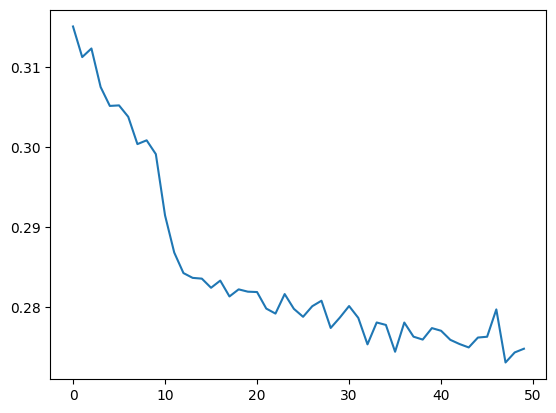

In [34]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [28]:
# put layers into eval mode
for layer in layers:
    layer.training = False

In [29]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr,Ytr),
        "val": (Xdev,Ydev),
        "test":(Xte,Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss("train")
split_loss("val")


train 1.862178087234497
val 2.2313666343688965
